In [3]:
!pip install pandas numpy yfinance pandas_datareader scikit-learn

  Using cached numpy-2.3.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 949.2/949.2 kB 45.8 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements

In [41]:
# ======================
# 1. 라이브러리 및 패키지 임포트
# ======================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as pdr
from sklearn.preprocessing import StandardScaler
from datetime import datetime

ModuleNotFoundError: No module named 'distutils'

In [12]:
# ======================
# 2. 각 데이터 불러오기 (gold_data 폴더에서)
# ======================

print("gold_data 폴더에서 데이터 로딩 시작...")

# 데이터 경로
data_path = "./gold_data/"

# 각 파일별로 데이터 로딩
data_files = {}

# 01번부터 13번까지 파일 로딩
for i in range(1, 14):
    file_num = f"{i:02d}"  # 01, 02, 03, ... 13
    try:
        file_path = f"{data_path}{file_num}*.csv"
        import glob
        matching_files = glob.glob(file_path)
        
        if matching_files:
            # 첫 번째 매칭 파일 사용
            df = pd.read_csv(matching_files[0], index_col=0, parse_dates=True)
            data_files[f"data_{file_num}"] = df
            print(f"{file_num}번 파일 로딩 완료: {df.shape}")
        else:
            print(f"{file_num}번 파일을 찾을 수 없습니다.")
            
    except Exception as e:
        print(f"{file_num}번 파일 로딩 실패: {e}")

print(f"총 {len(data_files)}개 파일 로딩 완료")

# 로딩된 데이터 확인
for key, df in data_files.items():
    print(f"{key}: {df.shape}, 컬럼: {list(df.columns)}")

gold_data 폴더에서 데이터 로딩 시작...
01번 파일 로딩 완료: (186, 5)
02번 파일 로딩 완료: (186, 1)
03번 파일 로딩 완료: (186, 1)
04번 파일 로딩 완료: (186, 2)
05번 파일 로딩 완료: (186, 10)
06번 파일 로딩 완료: (186, 2)
07번 파일을 찾을 수 없습니다.
08번 파일 로딩 완료: (186, 5)
09번 파일 로딩 완료: (186, 6)
10번 파일 로딩 완료: (186, 5)
11번 파일 로딩 완료: (186, 5)
12번 파일 로딩 완료: (186, 5)
13번 파일 로딩 완료: (186, 1)
총 12개 파일 로딩 완료
data_01: (186, 5), 컬럼: ['Close', 'High', 'Low', 'Open', 'Volume']
data_02: (186, 1), 컬럼: ['M2_Money_Supply_Billions_USD']
data_03: (186, 1), 컬럼: ['CPIAUCNS']
data_04: (186, 2), 컬럼: ['Close', 'Volume']
data_05: (186, 10), 컬럼: ['Gold_Reserves_United_States', 'Gold_Reserves_Germany', 'Gold_Reserves_Italy', 'Gold_Reserves_France', 'Gold_Reserves_Russia', 'Gold_Reserves_China', 'Gold_Reserves_Switzerland', 'Gold_Reserves_Japan', 'Gold_Reserves_India', 'Gold_Reserves_Netherlands']
data_06: (186, 2), 컬럼: ['USD_CNY_Rate', 'USD_EUR_Rate']
data_08: (186, 5), 컬럼: ['Close', 'High', 'Low', 'Open', 'Volume']
data_09: (186, 6), 컬럼: ['Price', 'Close', 'High', 'Low', 'O

In [24]:
# ======================
# 2-1. 필요한 컬럼만 추출 (CLOSE, Volume)
# ======================

print("필요한 컬럼 추출 중...")

extracted_data = {}

# 컬럼 찾기 함수
def find_column(df, target_names):
    """대소문자 구분 없이 컬럼 찾기"""
    for target in target_names:
        for col in df.columns:
            if col.upper() == target.upper():
                return col
    return None

# 각 파일별로 필요한 컬럼 추출
for i in range(1, 14):
    file_num = f"{i:02d}"
    data_key = f"data_{file_num}"
    
    if data_key in data_files:
        df = data_files[data_key]
        print(f"\n{file_num}번 파일 컬럼: {list(df.columns)}")
        
        # 파일별 컬럼 추출 규칙
        if file_num == "01":  # 종속변수 - CLOSE만
            close_col = find_column(df, ['CLOSE', 'Close', 'close'])
            if close_col:
                extracted_data[f"feature_{file_num}"] = df[close_col]
                print(f"{file_num}번: {close_col} 추출 (종속변수)")
            else:
                # CLOSE가 없으면 첫 번째 컬럼 사용
                first_col = df.columns[0]
                extracted_data[f"feature_{file_num}"] = df[first_col]
                print(f"{file_num}번: {first_col} 추출 (CLOSE 없어서 첫번째 컬럼 사용)")
                
        elif file_num == "04":  # Volume 컬럼에서 'Volume'
            volume_col = find_column(df, ['Volume', 'VOLUME', 'volume'])
            if volume_col:
                extracted_data[f"feature_{file_num}"] = df[volume_col]
                print(f"{file_num}번: {volume_col} 추출")
            else:
                # Volume이 없으면 첫 번째 컬럼 사용
                first_col = df.columns[0]
                extracted_data[f"feature_{file_num}"] = df[first_col]
                print(f"{file_num}번: {first_col} 추출 (Volume 없어서 첫번째 컬럼 사용)")
                
        elif file_num in ["05", "06"]:  # 05, 06번은 모든 컬럼 포함
            for col in df.columns:
                feature_name = f"feature_{file_num}_{col}"
                extracted_data[feature_name] = df[col]
            print(f"{file_num}번: 모든 컬럼 추출 ({len(df.columns)}개)")
                
        elif file_num in ["08", "09", "10", "11"]:  # CLOSE만
            close_col = find_column(df, ['CLOSE', 'Close', 'close'])
            if close_col:
                extracted_data[f"feature_{file_num}"] = df[close_col]
                print(f"{file_num}번: {close_col} 추출")
            else:
                # CLOSE가 없으면 첫 번째 컬럼 사용
                first_col = df.columns[0]
                extracted_data[f"feature_{file_num}"] = df[first_col]
                print(f"{file_num}번: {first_col} 추출 (CLOSE 없어서 첫번째 컬럼 사용)")
                
        else:  # 나머지는 CLOSE 우선, 없으면 첫 번째 컬럼
            close_col = find_column(df, ['CLOSE', 'Close', 'close'])
            if close_col:
                extracted_data[f"feature_{file_num}"] = df[close_col]
                print(f"{file_num}번: {close_col} 추출")
            else:
                # CLOSE가 없으면 첫 번째 컬럼 사용
                first_col = df.columns[0]
                extracted_data[f"feature_{file_num}"] = df[first_col]
                print(f"{file_num}번: {first_col} 추출 (CLOSE 없어서 첫번째 컬럼 사용)")

print(f"\n추출된 피쳐 수: {len(extracted_data)}개")

# 추출된 데이터 미리보기
for key, series in extracted_data.items():
    print(f"{key}: {len(series)}개 데이터, 기간: {series.index[0]} ~ {series.index[-1]}")

필요한 컬럼 추출 중...

01번 파일 컬럼: ['Close', 'High', 'Low', 'Open', 'Volume']
01번: Close 추출 (종속변수)

02번 파일 컬럼: ['M2_Money_Supply_Billions_USD']
02번: M2_Money_Supply_Billions_USD 추출 (CLOSE 없어서 첫번째 컬럼 사용)

03번 파일 컬럼: ['CPIAUCNS']
03번: CPIAUCNS 추출 (CLOSE 없어서 첫번째 컬럼 사용)

04번 파일 컬럼: ['Close', 'Volume']
04번: Volume 추출

05번 파일 컬럼: ['Gold_Reserves_United_States', 'Gold_Reserves_Germany', 'Gold_Reserves_Italy', 'Gold_Reserves_France', 'Gold_Reserves_Russia', 'Gold_Reserves_China', 'Gold_Reserves_Switzerland', 'Gold_Reserves_Japan', 'Gold_Reserves_India', 'Gold_Reserves_Netherlands']
05번: 모든 컬럼 추출 (10개)

06번 파일 컬럼: ['USD_CNY_Rate', 'USD_EUR_Rate']
06번: 모든 컬럼 추출 (2개)

08번 파일 컬럼: ['Close', 'High', 'Low', 'Open', 'Volume']
08번: Close 추출

09번 파일 컬럼: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
09번: Close 추출

10번 파일 컬럼: ['Close', 'High', 'Low', 'Open', 'Volume']
10번: Close 추출

11번 파일 컬럼: ['Open', 'High', 'Low', 'Close', 'Volume']
11번: Close 추출

12번 파일 컬럼: ['close', 'open', 'high', 'low', 'change_pct']

In [13]:
# ======================
# 2-2. 모든 데이터 날짜 형식 통일 (YYYY-MM)
# ======================

print("모든 데이터 날짜 형식 통일 중...")

# 날짜 형식을 YYYY-MM으로 통일하는 함수
def standardize_date_index(series, series_name):
    """날짜 인덱스를 YYYY-MM 형식으로 통일"""
    try:
        print(f"  {series_name} 날짜 변환 시작...")
        print(f"     원본 인덱스 타입: {type(series.index)}")
        print(f"     원본 인덱스 샘플: {series.index[:3].tolist()}")
        
        # 인덱스를 datetime으로 변환
        if not isinstance(series.index, pd.DatetimeIndex):
            # 문자열 인덱스인 경우 datetime으로 변환
            series.index = pd.to_datetime(series.index, errors='coerce')
            print(f"     datetime 변환 완료")
        
        # NaT 값 확인
        if series.index.isna().any():
            print(f" 변환할 수 없는 날짜가 있습니다. NaT 제거...")
            series = series[~series.index.isna()]
        
        # 월말 날짜로 통일
        series.index = series.index.to_period('M').to_timestamp('M')
        
        print(f"     {series_name}: 날짜 형식 통일 완료")
        print(f"     기간: {series.index[0].strftime('%Y-%m')} ~ {series.index[-1].strftime('%Y-%m')}")
        print(f"     데이터 개수: {len(series)}개")
        
        return series
        
    except Exception as e:
        print(f"     {series_name}: 날짜 형식 통일 실패 - {e}")
        print(f"     원본 인덱스: {series.index[:5].tolist()}")
        return series

# 모든 추출된 데이터의 날짜 형식 통일
standardized_data = {}

print(f"\n총 {len(extracted_data)}개 데이터의 날짜 형식 통일:")

for key, series in extracted_data.items():
    print(f"\n{key} 처리 중...")
    
    # 원본 정보 출력
    try:
        if isinstance(series.index[0], str):
            print(f"   원본 기간: {series.index[0]} ~ {series.index[-1]} (문자열)")
        else:
            print(f"   원본 기간: {series.index[0]} ~ {series.index[-1]}")
    except:
        print(f"   원본 기간: 인덱스 정보 확인 불가")
    
    # 날짜 형식 통일
    standardized_series = standardize_date_index(series.copy(), key)
    standardized_data[key] = standardized_series

print(f"\n모든 데이터 날짜 형식 통일 완료!")

# 통일된 데이터 정보 확인
print(f"\n날짜 통일 후 데이터 정보:")
for key, series in standardized_data.items():
    try:
        if len(series) > 0 and isinstance(series.index[0], pd.Timestamp):
            print(f"  {key}: {len(series)}개, {series.index[0].strftime('%Y-%m')} ~ {series.index[-1].strftime('%Y-%m')}")
        else:
            print(f"  {key}: {len(series)}개, 날짜 형식 확인 필요")
    except Exception as e:
        print(f"  {key}: {len(series)}개, 날짜 정보 오류 - {e}")

# 공통 날짜 범위 확인
try:
    valid_series = []
    for series in standardized_data.values():
        if len(series) > 0 and isinstance(series.index[0], pd.Timestamp):
            valid_series.append(series)
    
    if valid_series:
        all_start_dates = [series.index[0] for series in valid_series]
        all_end_dates = [series.index[-1] for series in valid_series]
        
        common_start = max(all_start_dates)
        common_end = min(all_end_dates)
        
        print(f"\n모든 데이터의 공통 기간: {common_start.strftime('%Y-%m')} ~ {common_end.strftime('%Y-%m')}")
    else:
        print(f"\n유효한 날짜 데이터가 없습니다.")
        
except Exception as e:
    print(f"\n공통 날짜 범위 계산 실패: {e}")

# extracted_data를 standardized_data로 업데이트
extracted_data = standardized_data
print(f"\n extracted_data 업데이트 완료")

모든 데이터 날짜 형식 통일 중...


NameError: name 'extracted_data' is not defined

In [14]:
# ======================
# 3. 데이터 통합 및 병합
# ======================

print("데이터 통합 중...")

# 추출된 데이터들을 DataFrame으로 병합
all_features = []
feature_names = []

# 각 데이터의 정보 확인
print("\n추출된 데이터 정보:")
for key, series in extracted_data.items():
    print(f"{key}: {len(series)}개, {series.index[0]} ~ {series.index[-1]}")

# 피쳐 이름 매핑 (각 파일에 맞는 의미있는 이름)
feature_name_mapping = {
    'feature_01': 'Gold_Price',           # 금시세 (종속변수)
    'feature_02': 'US_M2_Money_Supply',   # 미국 M2통화량
    'feature_03': 'US_CPI',               # 미국 소비자물가지수
    'feature_04': 'Gold_Volume',          # 금 거래량
    'feature_05': 'Gold_Reserves',        # 금 보유량 (05번 파일의 모든 컬럼들)
    'feature_06': 'Exchange_Rates',       # 환율 관련 (06번 파일의 모든 컬럼들)
    'feature_07': 'Silver_Price',         # 은 시세
    'feature_08': 'Dollar_Index',         # 달러지수
    'feature_09': 'SP500',                # S&P 500
    'feature_10': 'NASDAQ',               # 나스닥
    'feature_11': 'Bond_Rate',            # 채권금리
    'feature_12': 'VIX',                  # VIX 공포지수
    'feature_13': 'Additional_Economic'   # 추가 경제지표
}

# 모든 추출된 피쳐를 정렬하여 추가
# 01번부터 13번까지 순서 유지
sorted_keys = sorted(extracted_data.keys(), key=lambda x: (
    int(x.split('_')[1]), x.split('_')[2] if len(x.split('_')) > 2 else ''
))

print(f"\n정렬된 키 순서: {sorted_keys}")

for feature_key in sorted_keys:
    series = extracted_data[feature_key]
    
    # 의미있는 피쳐 이름 생성
    if feature_key.startswith('feature_05_'):
        # 05번 파일의 각 컬럼
        suffix = feature_key.replace('feature_05_', '')
        meaningful_name = f'Gold_Reserves_{suffix}'
    elif feature_key.startswith('feature_06_'):
        # 06번 파일의 각 컬럼
        suffix = feature_key.replace('feature_06_', '')
        meaningful_name = f'Exchange_Rate_{suffix}'
    else:
        # 단일 컬럼 파일들
        base_key = '_'.join(feature_key.split('_')[:2])  # feature_01, feature_02 등
        meaningful_name = feature_name_mapping.get(base_key, feature_key)
    
    series.name = meaningful_name
    all_features.append(series)
    feature_names.append(meaningful_name)
    print(f"{feature_key} -> {meaningful_name} 추가됨 (크기: {len(series)})")

# 모든 피쳐를 하나의 DataFrame으로 병합
if all_features:
    print(f"\n{len(all_features)}개 시리즈 병합 시작...")
    
    # 각 시리즈의 날짜 범위 확인
    print("\n각 피쳐의 날짜 범위:")
    for feature in all_features:
        print(f"  {feature.name}: {feature.index[0]} ~ {feature.index[-1]} ({len(feature)}개)")
    
    # 공통 날짜 범위 찾기 (inner join으로 결측치 최소화)
    print("\n공통 날짜 범위 계산 중...")
    
    # 모든 피쳐의 시작/끝 날짜 수집
    start_dates = [feature.index[0] for feature in all_features if len(feature) > 0]
    end_dates = [feature.index[-1] for feature in all_features if len(feature) > 0]
    
    if start_dates and end_dates:
        common_start = max(start_dates)  # 가장 늦은 시작 날짜
        common_end = min(end_dates)      # 가장 이른 종료 날짜
        
        print(f"공통 기간: {common_start} ~ {common_end}")
        
        # 공통 기간으로 모든 시리즈 필터링
        filtered_features = []
        for feature in all_features:
            # 공통 기간 내의 데이터만 선택
            mask = (feature.index >= common_start) & (feature.index <= common_end)
            filtered_feature = feature[mask]
            
            if len(filtered_feature) > 0:
                filtered_features.append(filtered_feature)
                print(f"  {feature.name}: {len(filtered_feature)}개 데이터 (필터링 후)")
            else:
                print(f"  {feature.name}: 공통 기간에 데이터 없음 - 제외")
        
        # 필터링된 피쳐들로 병합 (outer join)
        if filtered_features:
            combined_data = pd.concat(filtered_features, axis=1, join='outer')
            
            print(f"\n병합 후 크기: {combined_data.shape}")
            print(f"병합 후 기간: {combined_data.index[0]} ~ {combined_data.index[-1]}")
            
            # 결측치 확인
            print(f"\n병합 후 결측치 현황:")
            missing_counts = combined_data.isnull().sum()
            total_missing = missing_counts.sum()
            
            if total_missing > 0:
                print(f"총 결측치: {total_missing}개")
                for col, missing in missing_counts.items():
                    if missing > 0:
                        missing_pct = (missing / len(combined_data)) * 100
                        print(f"  {col}: {missing}개 ({missing_pct:.1f}%)")
            else:
                print("✅ 결측치가 없습니다!")
            
            print("데이터 통합 완료")
            print(f"최종 통합 데이터 크기: {combined_data.shape}")
            print(f"최종 기간: {combined_data.index[0]} ~ {combined_data.index[-1]}")
            
            # 원본 통합 데이터 저장 (스케일링 전)
            raw_filename = "gold_data_raw_combined.csv"
            combined_data.to_csv(raw_filename, encoding='utf-8-sig')
            print(f"원본 통합 데이터 저장: {raw_filename}")
            
            # 컬럼 정보 출력
            print("\n최종 피쳐 목록:")
            for i, col in enumerate(combined_data.columns, 1):
                print(f"  {i:2d}. {col}")
            
            # 각 컬럼의 유효 데이터 개수 확인
            print(f"\n각 컬럼별 유효 데이터 개수:")
            for col in combined_data.columns:
                valid_count = combined_data[col].count()
                total_count = len(combined_data)
                coverage = valid_count/total_count*100
                print(f"  {col}: {valid_count}/{total_count} ({coverage:.1f}%)")
            
            print("\n데이터 미리보기:")
            print(combined_data.head(10))
            
            print("\n데이터 끝부분:")
            print(combined_data.tail(10))
            
        else:
            print("❌ 공통 기간에 유효한 데이터가 없습니다.")
            combined_data = pd.DataFrame()
    else:
        print("❌ 유효한 날짜 범위를 찾을 수 없습니다.")
        combined_data = pd.DataFrame()
    
else:
    print("❌ 병합할 데이터가 없습니다.")
    combined_data = pd.DataFrame()

데이터 통합 중...

추출된 데이터 정보:


NameError: name 'extracted_data' is not defined

In [15]:
combined_data

NameError: name 'combined_data' is not defined

In [16]:
# ======================
# 4. 결측치 처리 및 보간
# ======================

print("🔄 결측치 처리 중...")

if not combined_data.empty:
    # 결측치 확인
    print("📊 결측치 현황:")
    missing_info = combined_data.isnull().sum()
    total_missing = missing_info.sum()
    
    print(f"전체 데이터 크기: {combined_data.shape}")
    print(f"총 결측치: {total_missing}개")
    
    if total_missing > 0:
        print("\n각 컬럼별 결측치:")
        for col, missing_count in missing_info.items():
            if missing_count > 0:
                missing_pct = (missing_count / len(combined_data)) * 100
                print(f"  {col}: {missing_count}개 ({missing_pct:.1f}%)")
        
        # 결측치가 너무 많은 컬럼은 제거 (50% 이상 결측치)
        high_missing_cols = []
        for col, missing_count in missing_info.items():
            missing_pct = (missing_count / len(combined_data)) * 100
            if missing_pct > 50:
                high_missing_cols.append(col)
        
        if high_missing_cols:
            print(f"\n🗑️ 결측치가 50% 이상인 컬럼 제거: {high_missing_cols}")
            combined_data = combined_data.drop(columns=high_missing_cols)
            print(f"제거 후 데이터 크기: {combined_data.shape}")
        
        # 선형 보간법으로 결측치 처리
        print("\n🔧 선형 보간법 적용 중...")
        data_interpolated = combined_data.interpolate(method='linear', limit_direction='both')
        
        # 여전히 남은 결측치는 앞뒤 값으로 채우기
        print("🔧 앞뒤 값으로 채우기...")
        data_filled = data_interpolated.fillna(method='ffill').fillna(method='bfill')
        
        # 최종 결측치 확인
        remaining_missing = data_filled.isnull().sum().sum()
        print(f"✅ 보간 후 남은 결측치: {remaining_missing}개")
        
        if remaining_missing > 0:
            print("⚠️ 여전히 결측치가 있습니다. 해당 행 제거...")
            print("결측치가 있는 컬럼들:")
            remaining_nulls = data_filled.isnull().sum()
            for col, null_count in remaining_nulls.items():
                if null_count > 0:
                    print(f"  {col}: {null_count}개")
            
            # 결측치가 있는 행 제거
            data_filled = data_filled.dropna()
            print(f"결측치 제거 후 데이터 크기: {data_filled.shape}")
    else:
        print("✅ 결측치가 없습니다!")
        data_filled = combined_data.copy()
    
    # 완전한 데이터만 사용
    final_data = data_filled.copy()
    
    print(f"\n✅ 최종 데이터 크기: {final_data.shape}")
    if len(final_data) > 0:
        print(f"📅 최종 기간: {final_data.index[0]} ~ {final_data.index[-1]}")
        
        # 기초 통계 확인
        print("\n📈 기초 통계 (처음 5개 컬럼):")
        print(final_data.iloc[:, :5].describe().round(2))
        
        print(f"\n📊 각 컬럼별 데이터 요약:")
        for col in final_data.columns:
            data_count = len(final_data[col])
            data_mean = final_data[col].mean()
            data_std = final_data[col].std()
            print(f"  {col}: {data_count}개, 평균={data_mean:.2f}, 표준편차={data_std:.2f}")
    else:
        print("❌ 최종 데이터가 비어있습니다.")
    
else:
    print("❌ 처리할 데이터가 없습니다.")
    final_data = pd.DataFrame()

🔄 결측치 처리 중...


NameError: name 'combined_data' is not defined

In [ ]:
# ======================
# 5. 데이터 스케일링 및 최종 저장
# ======================

print("🔄 데이터 스케일링 중...")

if not final_data.empty:
    # X(독립변수)와 y(종속변수) 분리
    # Gold_Price(01번)을 종속변수로 사용
    if 'Gold_Price' in final_data.columns:
        y = final_data['Gold_Price']  # 종속변수
        X = final_data.drop('Gold_Price', axis=1)  # 독립변수
    else:
        # Gold_Price가 없으면 첫 번째 컬럼을 종속변수로 사용
        y = final_data.iloc[:, 0]
        X = final_data.iloc[:, 1:]
    
    print(f"📊 독립변수 개수: {X.shape[1]}개")
    print(f"📊 데이터 개수: {X.shape[0]}개")
    print(f"🎯 종속변수: {y.name}")
    
    # StandardScaler 적용 (독립변수만)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 스케일링된 데이터를 DataFrame으로 변환
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    
    # 종속변수와 결합 (날짜 포함)
    final_scaled_data = pd.concat([X_scaled_df, y], axis=1)
    
    print("✅ 스케일링 완료")
    
    # 스케일링된 데이터 저장 (모델링용)
    scaled_filename = "gold_data_scaled_for_modeling.csv"
    final_scaled_data.to_csv(scaled_filename, encoding='utf-8-sig')
    
    print(f"💾 스케일링된 데이터 저장: {scaled_filename}")
    
    # 최종 요약
    print("\n" + "="*60)
    print("📋 저장된 파일 요약")
    print("="*60)
    print(f"📁 원본 통합 파일: gold_data_raw_combined.csv")
    print(f"📁 스케일링된 파일: {scaled_filename}")
    print(f"📊 데이터 크기: {final_scaled_data.shape}")
    print(f"📅 기간: {final_scaled_data.index[0]} ~ {final_scaled_data.index[-1]}")
    print(f"🎯 종속변수: {y.name}")
    print(f"📈 독립변수: {len(X.columns)}개")
    
    print("\n📝 독립변수 목록:")
    for i, col in enumerate(X.columns, 1):
        print(f"  {i:2d}. {col}")
    
    print("\n📝 최종 데이터 (상위 5행):")
    print(final_scaled_data.head())
    
    print("\n🔥 모델링 준비 완료!")
    print("="*60)
    
else:
    print("❌ 스케일링할 데이터가 없습니다.")

In [43]:
df = pd.read_csv('C:\gold_prediction_project\gold_data\gold_data_raw_combined.csv')
df

,Date_YYYY_MM,Gold_Price,US_M2_Money_Supply,US_CPI,Gold_Volume,Gold_Reserves_Gold_Reserves_United_States,Gold_Reserves_Gold_Reserves_Germany,Gold_Reserves_Gold_Reserves_Italy,Gold_Reserves_Gold_Reserves_France,Gold_Reserves_Gold_Reserves_Russia,...,Gold_Reserves_Gold_Reserves_India,Gold_Reserves_Gold_Reserves_Netherlands,Exchange_Rate_USD_CNY_Rate,Exchange_Rate_USD_EUR_Rate,Dollar_Index,SP500,NASDAQ,Bond_Rate,VIX,Additional_Economic
0,2010-01,1116.826300,8478.0,216.687,347218200,8214.300491,3392.470250,2476.156875,2461.108854,2322.747858,...,767.954029,618.584748,6.826916,1.426574,15.900000,79.500000,1073.869995,2147.350098,3.588,20.643158
1,2010-02,1098.189479,8527.6,216.741,368010500,8111.008546,3349.811128,2445.020072,2430.161274,2293.540119,...,758.297277,610.806262,6.828463,1.367995,16.070000,81.339996,1104.489990,2238.260010,3.619,22.540000
2,2010-03,1114.356525,8523.7,217.631,326092400,8238.859494,3402.613011,2483.560055,2468.467044,2329.692377,...,770.250047,620.434185,6.826183,1.357004,17.139999,82.239998,1169.430054,2397.959961,3.833,17.767391
3,2010-04,1151.452375,8555.1,218.009,274413100,8381.251267,3461.420192,2526.483292,2511.129429,2369.956327,...,783.562238,631.157116,6.825550,1.341682,18.260000,82.709999,1186.689941,2461.189941,3.659,17.424286
4,2010-05,1203.955005,8609.3,218.178,504968200,8095.410271,3343.369108,2440.318055,2425.487833,2289.129413,...,756.838995,609.631621,6.827450,1.256315,18.030001,87.459999,1089.410034,2257.040039,3.303,31.929500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2025-02,2897.115800,21584.2,319.082,178992600,7994.066180,3301.514441,2409.768422,2395.123855,2260.472467,...,747.364348,601.999820,7.273432,1.041300,28.309999,109.879997,5954.500000,18847.279297,4.202,16.968000
182,2025-03,2986.409528,21656.9,319.799,181005700,7959.297917,3287.155300,2399.287715,2384.706841,2250.641087,...,744.113867,599.381567,7.249252,1.081314,30.990000,107.559998,5611.850098,17299.289062,4.210,21.841429
183,2025-04,3211.152367,21804.7,320.795,354296400,8211.983788,3391.513462,2475.458517,2460.414741,2322.092766,...,767.737440,618.410287,7.296782,1.123177,29.600000,104.370003,5569.060059,17446.339844,4.175,31.966190
184,2025-05,3280.738095,21883.9,321.465,235215100,8097.149309,3344.087323,2440.842279,2426.008871,2289.621159,...,757.001578,609.762581,7.216557,1.127367,30.000000,101.980003,5911.689941,19113.769531,4.418,20.462273


In [46]:
!pip install seaborn

In [49]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   -- ------------------------------------- 3.9/56.8 MB 19.5 MB/s eta 0:00:03
   ------ --------------------------------- 9.4/56.8 MB 23.5 MB/s eta 0:00:03
   ---------- ----------------------------- 14.7/56.8 MB 23.1 MB/s eta 0:00:02
   -------------- ------------------------- 21.2/56.8 MB 25.3 MB/s eta 0:00:02
   ----------------- ---------------------- 24.6/56.8 MB 24.0 MB/s eta 0:00:02
   -------------------- ------------------- 29.6/56.8 MB 24.1 MB/s eta 0:00:02
   ----------------------- ---------------- 33.8/56.8 MB 23.3 MB/s eta 0:00:01
   ---------------------------- ----------- 40.6/56.8 MB 24.4 MB/s eta 0:00:01
   --------------------------------- ------ 46.9/56.8 MB 25.3 MB/s eta 0:00:01
   ------------------------------------- -- 53.7/56.8 MB 25.7 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 25.3 MB/s  0:00:02


In [58]:
!pip install tensorflow

  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   - -------------------------------------- 14.2/331.9 MB 74.3 MB/s eta 0:00:05
   - -------------------------------------- 15.2/331.9 MB 39.8 MB/s eta 0:00:08
   -- ------------------------------------- 18.4/331.9 MB 31.3 MB/s eta 0:00:11
   --- ------------------------------------ 33.0/331.9 MB 41.1 MB/s eta 0:00:08
   ----- ---------------------------------- 46.7/331.9 MB 46.4 MB/s eta 0:00:07
   -------- ------------------------------- 67.4/331.9 MB 55.1 MB/s eta 0:00:05
   ---------- ----------------------------- 89.7/331.9 MB 62.2 MB/s eta 0:00:04
   ------------ -------------------------- 104.3/331.9 MB 63.4 MB/s eta 0:00:04
   ------------- ------------------------- 110.9/331.9 MB 60.0 MB/s eta 0:00:04
   --

          Model        R2        RMSE         MAE
0  RandomForest -0.761433  621.072827  434.554537
1       XGBoost -0.533808  579.555455  388.423914


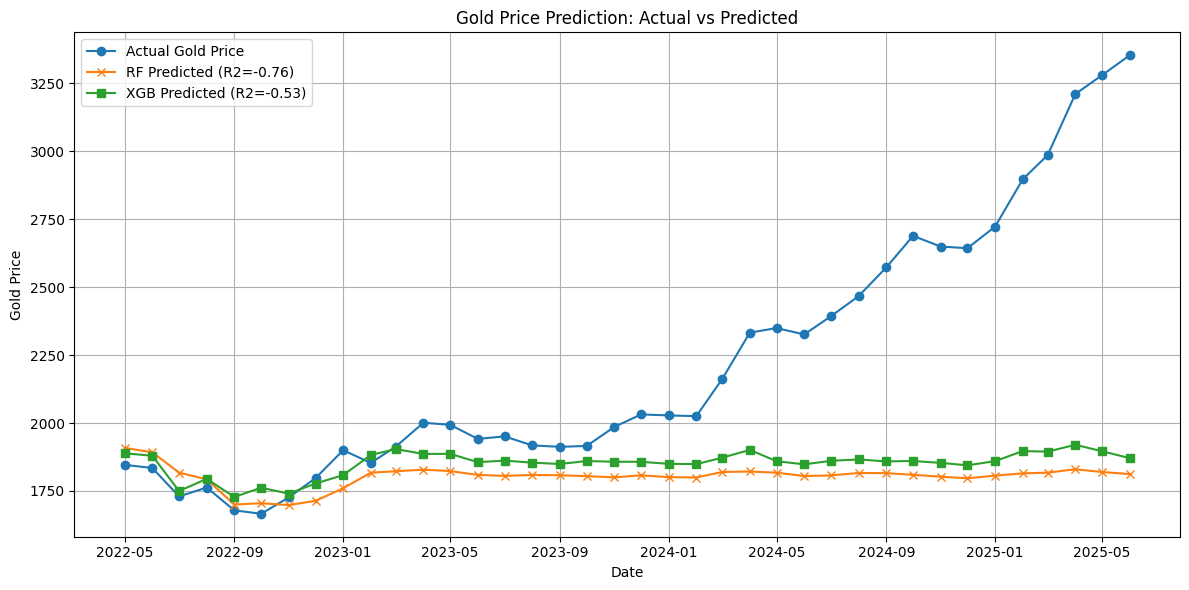

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================
# 1. 데이터 로드 및 피처 엔지니어링
# ==============================
file_path = 'C:\gold_prediction_project\gold_data\gold_data_raw_combined.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

# 날짜 기반 파생 변수
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['time_index'] = np.arange(len(df))

# Lag Features
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_lag6'] = df['Gold_Price'].shift(6)

# Rolling Features
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_vol3'] = df['Gold_Price'].rolling(3).std()
df['gold_roll6'] = df['Gold_Price'].rolling(6).mean()

# 증감률 Features
df['gold_return'] = df['Gold_Price'].pct_change()
df['m2_growth'] = df['US_M2_Money_Supply'].pct_change()
df['cpi_inflation'] = df['US_CPI'].pct_change()

# 주기성 인코딩
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)


# ==============================
# 2. 데이터 분리
# ==============================
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date"])
y = df["Gold_Price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# ==============================
# 3. 스케일링 + 모델링 (RF, XGB)
# ==============================
# RandomForest
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

# XGBoost
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

# ==============================
# 4. 결과 비교 출력
# ==============================
results = pd.DataFrame({
    "Model": ["RandomForest", "XGBoost"],
    "R2": [rf_r2, xgb_r2],
    "RMSE": [rf_rmse, xgb_rmse],
    "MAE": [rf_mae, xgb_mae]
})

print(results)

# ==============================
# 5. Plot 비교 (실제값 vs 예측값) - X축을 Date로 변경
# ==============================
test_dates = df.loc[y_test.index, "Date"]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test.values, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_rf, label=f"RF Predicted (R2={rf_r2:.2f})", marker='x')
plt.plot(test_dates, y_pred_xgb, label=f"XGB Predicted (R2={xgb_r2:.2f})", marker='s')
plt.title("Gold Price Prediction: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
LSTM 회귀 결과
R² Score  : 0.9470
RMSE      : 108.2357
MAE       : 81.9828


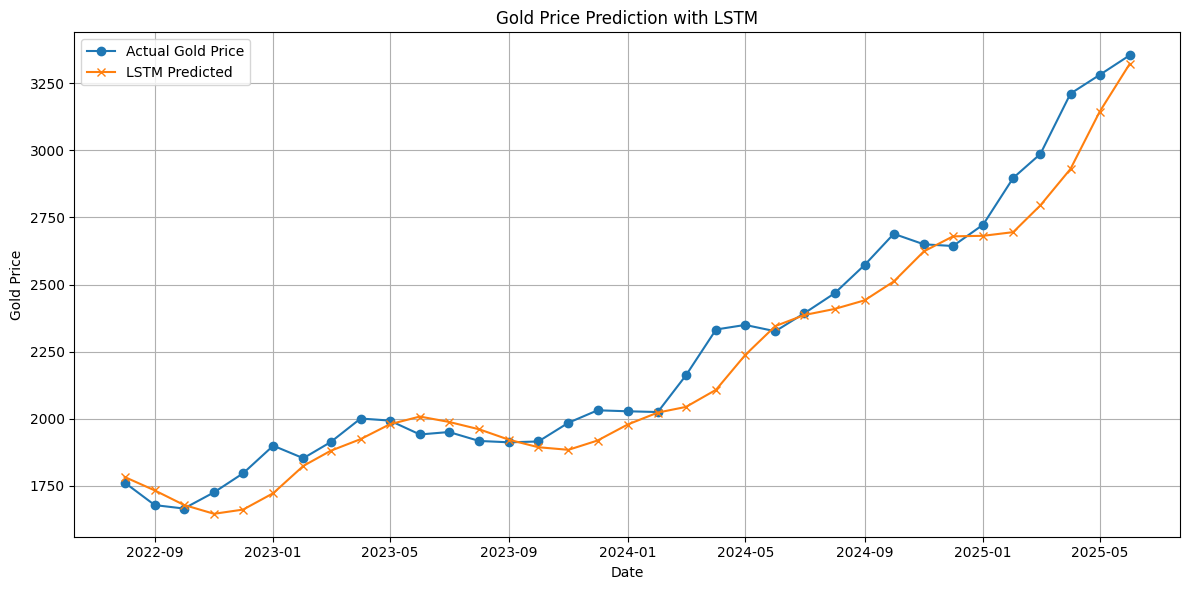

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ==============================
# 1. 데이터 준비
# ==============================
file_path = "C:\\gold_prediction_project\\gold_data\\gold_data_raw_combined.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

gold_prices = df['Gold_Price'].values.reshape(-1,1)

# 스케일링
scaler = MinMaxScaler()
gold_scaled = scaler.fit_transform(gold_prices)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 지난 12개월 데이터로 다음 달 예측
X, y = create_sequences(gold_scaled, seq_length)

# 학습/테스트 분리 (시계열이므로 shuffle=False)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==============================
# 2. LSTM 모델 정의
# ==============================
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred = model.predict(X_test)

# 스케일 복원
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 지표 계산
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("LSTM 회귀 결과")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")

# ==============================
# 4. 실제 vs 예측 시각화 (X축을 Date로 변경)
# ==============================
# 시퀀스 때문에 y_test의 시작 인덱스는 seq_length만큼 밀려 있음
test_dates = df['Date'].iloc[seq_length + split : seq_length + len(X)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_inv, label="LSTM Predicted", marker='x')
plt.title("Gold Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
GRU 회귀 결과
R² Score  : 0.9489
RMSE      : 106.3148
MAE       : 80.4568


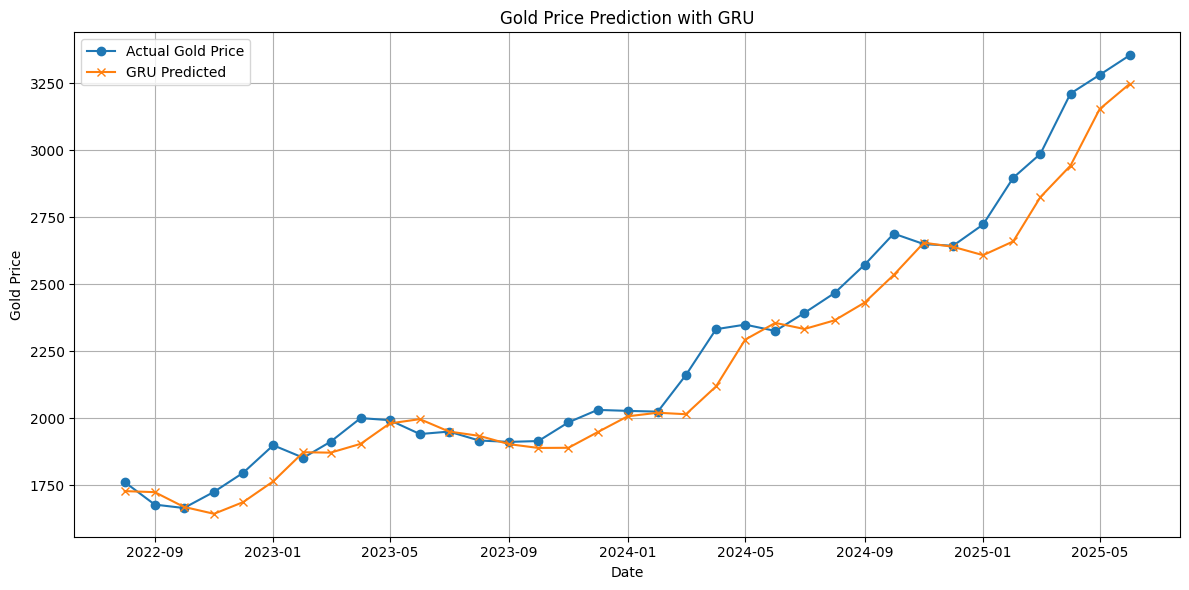

In [65]:
####### GRU #######

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# ==============================
# 1. 데이터 준비
# ==============================
file_path = "C:\\gold_prediction_project\\gold_data\\gold_data_raw_combined.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

gold_prices = df['Gold_Price'].values.reshape(-1,1)

# 스케일링
scaler = MinMaxScaler()
gold_scaled = scaler.fit_transform(gold_prices)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 지난 12개월 데이터로 다음 달 예측
X, y = create_sequences(gold_scaled, seq_length)

# 학습/테스트 분리 (80:20)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==============================
# 2. GRU 모델 정의
# ==============================
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred = model.predict(X_test)

# 스케일 복원
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 지표 계산
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("GRU 회귀 결과")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")

# ==============================
# 4. 실제 vs 예측 시각화 (X축을 Date로 변경)
# ==============================
# y_test의 시작은 seq_length + split 번째 데이터부터
test_dates = df['Date'].iloc[seq_length + split : seq_length + len(X)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_inv, label="GRU Predicted", marker='x')
plt.title("Gold Price Prediction with GRU")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
